TensorFlow Version: 2.18.0
Using dataset path: C:\Users\91947\Desktop\dap and iot\test\pro

--- Loading Trained Model ---
Model loaded successfully from models\best_osteoporosis_resnet50.keras


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,606,155 (90.05 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 12,296 (48.04 KB)


--- Loading Test Data (Using 20.0% validation split as test set) ---
Found 1947 files belonging to 3 classes.
Using 389 files for validation.
Test dataset classes: ['Normal', 'Osteopenia', 'Osteoporosis']

--- Preprocessing Test Data ---

--- Evaluating Model on Test Data ---
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8094 - loss: 0.4613

Test Loss: 0.4606
Test Accuracy: 0.8123 (81.23%)

--- Generating Predictions for Confusion Matrix ---
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
Number of predictions: 389
Number of true labels: 389

--- Generating Confusion Matrix ---
Confusion matrix saved to: plots\confusion_matrix.png

--- Classification Report (on Test Set) ---
              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000         0
  Osteopenia     0.0000    0.0000    0.0000         0
Osteoporosis     1.0000    0.8123    0.8965       389

    accuracy                         0.8123       389
   macro avg     0.3333    0.2708    0.2988  

C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


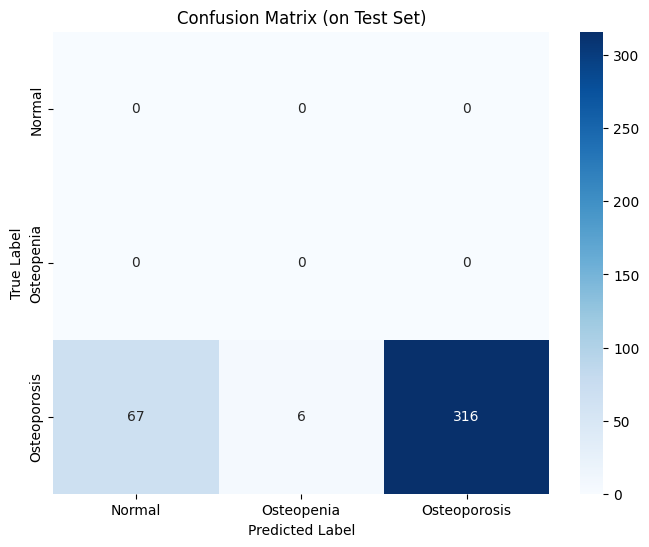

In [1]:
# evaluate_model.py
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib # Need pathlib

print("TensorFlow Version:", tf.__version__)

# --- Configuration Constants (Integrated) ---
# IMPORTANT: Update this path to your ACTUAL dataset directory
DATASET_PATH = pathlib.Path(r'C:\Users\91947\Desktop\dap and iot\test\pro') # <<<--- CHANGE THIS

MODEL_SAVE_PATH = pathlib.Path('./models')
PLOTS_SAVE_PATH = pathlib.Path('./plots')
MODEL_FILENAME = 'best_osteoporosis_resnet50.keras'

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2 # Must match the split used in training

# Ensure these EXACTLY match your folder names
CLASS_NAMES = ['Normal', 'Osteopenia', 'Osteoporosis']
NUM_CLASSES = len(CLASS_NAMES)

# Ensure plots directory exists (it might not if only this script is run)
PLOTS_SAVE_PATH.mkdir(parents=True, exist_ok=True)

# --- Validate Dataset Path ---
def check_dataset_path():
    if not DATASET_PATH.exists():
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"ERROR: Dataset path does not exist: {DATASET_PATH}")
        print(f"Please update DATASET_PATH at the top of this script.")
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        return False
    print(f"Using dataset path: {DATASET_PATH}")

    all_dirs_exist = True
    for class_name in CLASS_NAMES:
        class_dir = DATASET_PATH / class_name
        if not class_dir.is_dir():
            print(f"ERROR: Class directory not found: {class_dir}")
            all_dirs_exist = False

    if not all_dirs_exist:
         print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
         print(f"Please ensure subfolders matching CLASS_NAMES exist in {DATASET_PATH}")
         print(f"Expected: {CLASS_NAMES}")
         print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
         return False
    return True

if not check_dataset_path():
    exit("Exiting due to invalid dataset path.")

# --- 1. Load the Trained Model ---
print("\n--- Loading Trained Model ---")
model_path = MODEL_SAVE_PATH / MODEL_FILENAME
if not model_path.exists():
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"ERROR: Trained model not found at {model_path}")
    print(f"Please run train_model.py first.")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    exit("Exiting due to missing model file.")

try:
    model = load_model(str(model_path))
    print(f"Model loaded successfully from {model_path}")
    model.summary()
except Exception as e:
    print(f"Error loading model: {e}")
    exit("Exiting.")

# --- 2. Load Test Data ---
# Using the validation split as the test set (see comment in original evaluate_model.py)
print(f"\n--- Loading Test Data (Using {VALIDATION_SPLIT*100}% validation split as test set) ---")
try:
    test_ds = image_dataset_from_directory(
        DATASET_PATH,
        labels='inferred',
        label_mode='categorical',
        class_names=CLASS_NAMES,
        image_size=IMG_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=False, # No shuffling for evaluation
        seed=42, # Use same seed as training
        validation_split=VALIDATION_SPLIT,
        subset='validation' # Select the validation part
    )
    print("Test dataset classes:", test_ds.class_names)
except Exception as e:
    print(f"Error loading test dataset: {e}")
    exit()


# --- 3. Preprocess Test Data ---
def preprocess_resnet(image, label):
    image = preprocess_input(image)
    return image, label

print("\n--- Preprocessing Test Data ---")
test_ds = test_ds.map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# --- 4. Evaluate Model ---
print("\n--- Evaluating Model on Test Data ---")
loss, accuracy = model.evaluate(test_ds)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# --- 5. Generate Predictions and True Labels ---
print("\n--- Generating Predictions for Confusion Matrix ---")
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
try:
    for images, labels in test_ds:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_true = np.array(y_true)
    print(f"Number of predictions: {len(y_pred)}")
    print(f"Number of true labels: {len(y_true)}")
except Exception as e:
    print(f"Error extracting true labels: {e}")
    exit()


# --- 6. Generate and Plot Confusion Matrix ---
if len(y_pred) != len(y_true):
    print("Error: Mismatch between predictions and true labels!")
else:
    print("\n--- Generating Confusion Matrix ---")
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (on Test Set)')

    cm_filename = PLOTS_SAVE_PATH / 'confusion_matrix.png'
    plt.savefig(str(cm_filename))
    print(f"Confusion matrix saved to: {cm_filename}")
    # plt.show()

    # --- 7. Print Classification Report ---
    print("\n--- Classification Report (on Test Set) ---")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

print("\n--- Evaluation Script Complete ---")